# Plotting Time Series

Lets-Plot handles all temporal data types through a unified "datetime" scale (excluding duration/timedelta types, which are handled by the "time" scale). This is in contrast to R's ggplot2, which provides separate "date", "time", and "datetime" scales.

**Supported temporal data types:**

- Python `time` objects (time of day)
- Python `date` objects
- Python `datetime` objects (both naive and timezone-aware)
- NumPy `datetime64` objects
- Pandas Series with timezone information
- Polars Series with timezone information

In [1]:
from datetime import datetime, date, time, timedelta, timezone

import numpy as np
import pandas as pd

from lets_plot import *


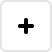
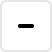
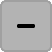
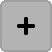
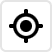
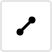
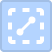
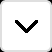
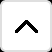
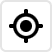
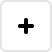
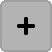
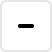
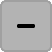
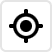
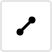
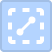
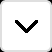
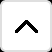
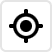

In [2]:
LetsPlot.setup_html()

In [3]:
def squiggle(x):
    return np.sin(3 * x) / (x * (np.cos(x) + 2))

In [4]:
N = 50
xs = np.linspace(1, 25, N)
ys = [squiggle(x) for x in xs ]

#### Local Time

Python `time` objects represent time-of-day values (local/clock time) independent of any specific date. 

The datetime scale renders these with default tooltips and scale breaks optimized for hours or smaller time units.

In [5]:
# Create time objects at regular intervals: every 12 minutes starting from 8:00 AM
start_time = time(8, 0)  # 8:00 AM
interval_minutes = 12
xs_time = []
for i in range(N):
    total_minutes = i * interval_minutes
    hours = 8 + total_minutes // 60
    minutes = total_minutes % 60
    xs_time.append(time(hours, minutes))

(ggplot(data = dict(xs=xs_time, ys=ys),
        mapping=aes('xs', 'ys'))
 + geom_band(
     xmin=time(12, 30),        # <-- Use a compatible datatype ('time' here) for a constant value.
     xmax=time(13, 30),
     tooltips=layer_tooltips()
         .title('Lunch Time')
         .line('^xmin - ^xmax')
         .line('in any time zone'))
 + geom_line(
     tooltips=layer_tooltips()
         .line("Time:|@xs")
         .format('^x', '%H:%M:%S'),
     color='#1380A1', size=2)
 + ggtb() + ggsize(800, 400)) + theme(axis_title='blank')

#### Date

Python `date` objects represent calendar dates without time information. 

`Date` objects are inherently timezone-agnostic since they contain no time component - a date like "2024-01-15" represents the same calendar day regardless of timezone.

The datetime scale renders these with default tooltips and scale breaks optimized for days or larger time units (weeks, months, years) depending on the data range.

In [6]:
# This covers March 15 - May 3, 2025
start_date = date(2025, 3, 15)
xs_date = []
for i in range(N):
    xs_date.append(start_date + timedelta(days=i))

(ggplot(data = dict(xs=xs_date, ys=ys),
        mapping=aes('xs', 'ys'))
 + geom_vline(
     xintercept=date(2025, 4, 1),
     tooltips=layer_tooltips()
         .title("April Fools' Day")
         .format('^xintercept', '%a, %b %e, %Y'),
     linetype='dotted', size=1.5)
 + geom_line(
     tooltips=layer_tooltips()
         .line('Date:|@xs')
         .format('^x', '%b %d, %Y'),
     color='#1380A1', size=2)
 + ggtb() + ggsize(800, 400)) + theme(axis_title='blank')

#### Date-Time

Python `datetime` objects represent both date and time information, either timezone-naive or timezone-aware. 

The datetime scale automatically adapts tooltips and scale breaks based on the data's temporal resolution.

**Timezone handling:** If no timezone information is present (naive datetime), Lets-Plot assumes UTC timezone. For timezone-aware datetime objects, the timezone information from the data is preserved and used for rendering.

In [7]:
# Berlin DST transition: March 30, 2025 at 2:00 AM
# Cover ±3 days: March 27 - April 2, 2025 (6 days total)

# Generate equally spaced UNIX timestamps (in seconds)
start_timestamp = datetime(2025, 3, 27, 0, 0, tzinfo=timezone.utc).timestamp()
end_timestamp = datetime(2025, 4, 2, 23, 59, tzinfo=timezone.utc).timestamp()
unix_timestamps = np.linspace(start_timestamp, end_timestamp, N)

# Convert to pandas datetime series with Berlin timezone
xs_datetime = pd.to_datetime(unix_timestamps, unit='s', utc=True).tz_convert('Europe/Berlin')

df = pd.DataFrame({
    'xs': xs_datetime,
    'ys': ys
})

p = (ggplot(data = df,
        mapping=aes('xs', 'ys'))
 + geom_vline(
     xintercept=pd.Timestamp('2025-03-30 01:59:59', tz='Europe/Berlin'),
     tooltips=layer_tooltips()
         .title('Berlin "spring forward" transition')
         .line('^xintercept').format('^xintercept', '%b %d, %Y %H:%M:%S')
         .line('2:00 AM → 3:00 AM'),
     linetype='dotted', size=1.5)
 + geom_line(
     tooltips=layer_tooltips()
         .line('@xs')
         .format('^x', '%b %d, %Y %H:%M'),
     color='#1380A1', size=2)
 + ggtb() + ggsize(800, 400)) + theme(axis_title='blank')

p

#### Zoomed View: Berlin Start of DST Transition Details

This plot zooms into the DST transition period: ±8 hours around March 30, 2025 at 2:00 AM.

Notice that the time 2025-03-30 02:00:00 through 2025-03-30 02:59:59 does not exist in Europe/Berlin timezone - clocks spring forward directly from 01:59:59 to 03:00:00, creating a gap in the timeline.

In [8]:
p + coord_cartesian(
    xlim=[
        pd.Timestamp('2025-03-29 21:00:00', tz='Europe/Berlin'),
        pd.Timestamp('2025-03-30 08:00:00', tz='Europe/Berlin')
    ]
)

#### Berlin End of DST Transition Details

The mirroring phenomenon can be observed during Berlin's end of DST transition: around October 26, 2025 at 2:00 AM.

Notice that the time 2025-10-26 02:00:00 through 2025-10-26 02:59:59 appears twice in Europe/Berlin timezone - clocks fall back from 02:59:59 to 02:00:00, creating a duplication in the timeline where the same hour occurs twice.

In [9]:
# Berlin DST transition back: October 26, 2025 at 3:00 AM → 2:00 AM

# Generate equally spaced UNIX timestamps (in seconds)
start_timestamp = datetime(2025, 10, 23, 0, 0, tzinfo=timezone.utc).timestamp()
end_timestamp = datetime(2025, 10, 29, 23, 59, tzinfo=timezone.utc).timestamp()
unix_timestamps = np.linspace(start_timestamp, end_timestamp, N)

# Convert to pandas datetime series with Berlin timezone
xs_datetime = pd.to_datetime(unix_timestamps, unit='s', utc=True).tz_convert('Europe/Berlin')

df = pd.DataFrame({
    'xs': xs_datetime,
    'ys': ys
})

p = (ggplot(data = df,
        mapping=aes('xs', 'ys'))
 + geom_vline(
     xintercept=pd.to_datetime('2025-10-26 00:59:59', utc=True).tz_convert('Europe/Berlin'),
     tooltips=layer_tooltips()
         .title('Berlin "fall back" transition')
         .line('^xintercept').format('^xintercept', '%b %d, %Y %H:%M:%S')
         .line('3:00 AM → 2:00 AM'),
     linetype='dotted', size=1.5)
 + geom_line(
     tooltips=layer_tooltips()
         .line('@xs')
         .format('^x', '%b %d, %Y %H:%M'),
     color='#1380A1', size=2)
 + ggtb() + ggsize(800, 400)) + theme(axis_title='blank')

p + coord_cartesian(
    xlim=[
        pd.Timestamp('2025-10-25 22:00:00', tz='Europe/Berlin'),
        pd.Timestamp('2025-10-26 08:00:00', tz='Europe/Berlin')
    ]
)